In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

In [5]:
# Load and preprocess the dataset
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data = data.drop(columns=['Name'])     # Drop the 'Name' column

    # Encoding categorical columns
    categorical_cols = ['Sex', 'Pclass']
    data = pd.get_dummies(data, columns=categorical_cols)

    # Min-max normalization
    numeric_cols = ['Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']
    for col in numeric_cols:
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

    return data

In [7]:
# Splitting data for cross-validation
def stratified_k_fold(data, k=10):
    data = data.sample(frac=1).reset_index(drop=True)
    folds = []
    targets = data['Survived']
    target_classes = targets.unique()

    for i in range(k):
        fold = pd.concat([data[targets == target].iloc[i::k] for target in target_classes])
        folds.append(fold)
    return folds


In [9]:
# Decision Tree implementation
class DecisionTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        if len(set(y)) == 1 or depth == self.max_depth or len(y) == 0:
            # Return the most common label
            most_common = y.mode()[0] if not y.empty else None
            return {'label': most_common}

        best_feature, best_threshold = self._choose_best_feature(X, y)
        if best_feature is None:
            return {'label': y.mode()[0]}

        left_idx = X[best_feature] < best_threshold
        right_idx = ~left_idx
        left_tree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_tree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold, 'left': left_tree, 'right': right_tree}

    def _choose_best_feature(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature in X.columns:
            thresholds = X[feature].unique()
            for t in thresholds:
                left_y = y[X[feature] < t]
                right_y = y[X[feature] >= t]
                if left_y.empty or right_y.empty:
                    continue
                gain = self._information_gain(y, left_y, right_y)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = t
        return best_feature, best_threshold


    def _information_gain(self, y, left_y, right_y):
        def entropy(y):
            proportions = y.value_counts(normalize=True)
            return -sum(proportions * np.log2(proportions))

        parent_entropy = entropy(y)
        n = len(y)
        n_left, n_right = len(left_y), len(right_y)
        child_entropy = (n_left / n) * entropy(left_y) + (n_right / n) * entropy(right_y)

        return parent_entropy - child_entropy

    def predict(self, X):
        predictions = X.apply(self._predict_row, axis=1)
        return predictions

    def _predict_row(self, row):
        node = self.tree
        while 'label' not in node:
            if row[node['feature']] < node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['label']

In [11]:
# Evaluate the model with different tree depths
def evaluate_decision_tree(data, depth_values):
    accuracy_results = []
    f1_results = []

    for depth in depth_values:
        accuracies = []
        f1_scores = []
        folds = stratified_k_fold(data)

        for i in range(len(folds)):
            train_folds = folds[:i] + folds[i + 1:]
            test_fold = folds[i]

            train_data = pd.concat(train_folds)
            test_data = test_fold

            X_train, y_train = train_data.drop(columns=['Survived'], axis=1), train_data['Survived']
            X_test, y_test = test_data.drop(columns=['Survived'], axis=1), test_data['Survived']

            tree = DecisionTree(max_depth=depth)
            tree.fit(X_train, y_train)
            predictions = tree.predict(X_test)

            accuracies.append(accuracy_score(y_test, predictions))
            f1_scores.append(f1_score(y_test, predictions))

        accuracy_results.append(np.mean(accuracies))
        f1_results.append(np.mean(f1_scores))

        print(f"Depth {depth}: Average Accuracy = {np.mean(accuracies)}, Average F1 Score = {np.mean(f1_scores)}")

    return depth_values, accuracy_results, f1_results

In [13]:
# Plotting the results
def plot_results(depths, accuracies, f1_scores):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(depths, accuracies, marker='o')
    plt.title('Accuracy vs Tree Depth')
    plt.xlabel('Depth of Decision Tree')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(depths, f1_scores, marker='o', color='red')
    plt.title('F1 Score vs Tree Depth')
    plt.xlabel('Depth of Decision Tree')
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()

Depth 3: Average Accuracy = 0.8173941663829304, Average F1 Score = 0.7500400747139737
Depth 5: Average Accuracy = 0.8309281012370899, Average F1 Score = 0.7638285804946479
Depth 7: Average Accuracy = 0.8172679037566679, Average F1 Score = 0.7430852853020435
Depth 10: Average Accuracy = 0.7927738054704346, Average F1 Score = 0.7131269540586644
Depth 12: Average Accuracy = 0.8004361025990239, Average F1 Score = 0.7201512797470666


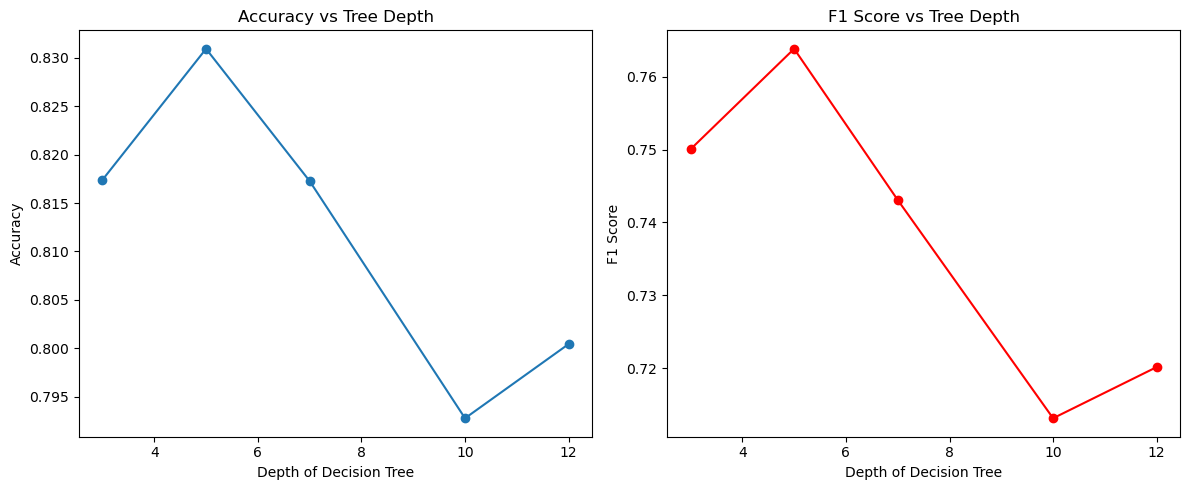

In [17]:
# Main execution
if __name__ == "__main__":
    filepath = 'titanic.csv'
    data = load_and_preprocess_data(filepath)
    depth_values = [3, 5, 7, 10, 12]
    depths, accuracies, f1_scores = evaluate_decision_tree(data, depth_values)
    plot_results(depths, accuracies, f1_scores)